## Synthetic data generation

In [1]:
# Setting parameters
#parameters
k_tr    = 0.3 # 20/min/gene
K_pol   = 10**(-6) # Molar
k_rdeg  = 10**(-3) # /s : 5 minutes half-life (t_h), k=ln(2)/t_h, k=0.7/300 ~ 10^(-3)
k_tl    = 10**(-1) # /s : 5/min/mRNA
K_rib   = 10**(-6) # ? Molar 
k_exc   = 2
K_T_rep = 10**(-9) # M
k_tp    = 1
k_cat   = 14 # /s
k_M     = 10**(-4) # Molar

# rangers for parameters
ranges = [
    ( 3*(10**(-2)), 3*(10**(0)) ),
    ( 10**(-7), 10**(-5) ),
    ( 10**(-4), 10**(-2) ),
    ( 10**(-2), 10**(0) ),
    ( 10**(-7), 10**(-5) ),
    ( 2*(10**(-1)), 2*(10**(1)) ),
    ( 10**(-10), 10**(-8) ),
    ( 10**(-1), 10**(1) ),
    ( 1.4*(10**(0)), 1.4*(10**(2)) ),
    ( 10**(-5), 10**(-3) ),
]

In [2]:
# Solving the ODE system
from scipy.integrate import odeint
from deriv_equations import deriv, ODE_residual_dict
import numpy as np

# A grid of time points (in days)
t = np.linspace(0, 10, 100) #from day 0 to day 500, generate 100 points

# Initial conditions
R_e_0 = 3
R_t_0 = 2
R_r_0 = 4
R_p_0 = 1

P_e_0 = 1
P_t_0 = 1
P_r_0 = 1
P_p_0 = 1

M_a_0 = 1
M_b_0 = 1

# Initial condition vectors
y0 = R_e_0, R_t_0 , R_r_0, R_p_0, P_e_0, P_t_0, P_r_0, P_p_0, M_a_0, M_b_0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(
    k_tr,
    K_pol,
    k_rdeg,
    k_tl,
    K_rib,
    k_exc,
    K_T_rep,
    k_tp,
    k_cat,
    k_M
))
R_e, R_t, R_r, R_p, P_e, P_t, P_r, P_p, M_a, M_b = ret.T

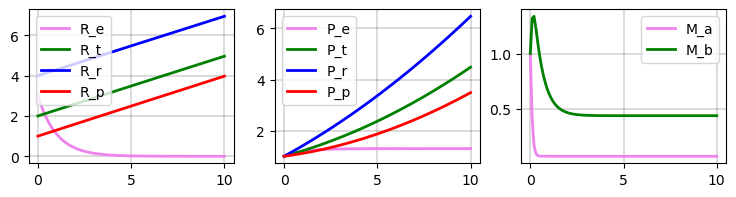

In [3]:
import matplotlib.pyplot as plt

# Plot the solved variables
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2))

ax0.plot(t, R_e, 'violet', lw=2, label='R_e')
ax0.plot(t, R_t, 'green', lw=2, label='R_t')
ax0.plot(t, R_r, 'blue', lw=2, label='R_r')
ax0.plot(t, R_p, 'red', lw=2, label='R_p')

ax0.grid(True, which='major', c='black', lw=0.2, ls='-')
ax0.legend()

ax1.plot(t, P_e, 'violet', lw=2, label='P_e')
ax1.plot(t, P_t, 'green', lw=2, label='P_t')
ax1.plot(t, P_r, 'blue', lw=2, label='P_r')
ax1.plot(t, P_p, 'red', lw=2, label='P_p')

ax1.grid(True, which='major', c='black', lw=0.2, ls='-')
ax1.legend()

ax2.plot(t, M_a, 'violet', lw=2, label='M_a')
ax2.plot(t, M_b, 'green', lw=2, label='M_b')

ax2.grid(True, which='major', c='black', lw=0.2, ls='-')
ax2.legend()

plt.show()

In [4]:
# Export generated data
mymodel_Data = np.asarray([t, R_e, R_t, R_r, R_p, P_e, P_t, P_r, P_p, M_a, M_b]) 
np.savetxt("mymodel_Data.csv", mymodel_Data, delimiter=",")

## Preamble

In [5]:
# Load data 
from numpy import genfromtxt
ode_data = genfromtxt('mymodel_Data.csv', delimiter=',') # in the form [t,R_e, R_t, R_r, R_p, P_e, P_t, P_r, P_p, M_a, M_b]

## Neural Network Training

In [6]:
# Training parameters 
learning_rate = 1e-6
# epoch_number = 1000000
epoch_number = 200000
# epoch_number = 50000
Base_LR = 1e-5
Max_LR = 1e-3
Step_Size_Up = 1000
Mode = "exp_range"
Gamma = 0.85
## not usable right now !
Cycle_Momentum = False

In [7]:
# Be careful : the variables have to be in the same order that in the ode_data
variables = ["R_e","R_t","R_r","R_p","P_e","P_t","P_r","P_p","M_a","M_b"]
variable_data = {v : ode_data[i+1] for i,v in enumerate(variables)}
variable_no_data  = {}
data_t = ode_data[0]

# test without M_b
# variables = ["R_e","R_t","R_r","R_p","P_e","P_t","P_r","P_p","M_a"]
# variable_data = {v : ode_data[i+1] for i,v in enumerate(variables)}
# variable_no_data  = {"M_b": M_b_0}

# variable wihtout data
# variable_no_data  = {"M_b": M_b_0}


parameters_names = ["k_tr","K_pol","k_rdeg","k_tl","K_rib","k_exc","K_T_rep","k_tp","k_cat","k_M",]

In [8]:
import torch
import torch.optim as optim
from pinn import Pinn

# Training

torch.manual_seed(42)
constants_dict = {"k_tr":k_tr,"K_pol":K_pol,"k_rdeg":k_rdeg,"k_tl":k_tl,"K_rib":K_rib,"k_exc":k_exc,"K_T_rep":K_T_rep,"k_tp":k_tp,"k_cat":k_cat,"k_M":k_M}

pinn_cell = Pinn(ode_residual_dict=ODE_residual_dict,
                 ranges=ranges,
                 data_t=data_t,
                 variables_data=variable_data,
                 variables_no_data=variable_no_data,
                 parameter_names=parameters_names,
                 constants_dict=constants_dict
                 )
    

optimizer = optim.Adam(
    pinn_cell.params,
    lr = learning_rate
    )
pinn_cell.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(
    pinn_cell.optimizer,
    base_lr=Base_LR,
    max_lr=Max_LR,
    step_size_up=Step_Size_Up,
    mode=Mode,
    gamma=Gamma,
    cycle_momentum=Cycle_Momentum
    )
pinn_cell.scheduler = scheduler

r2_store, pred_variables, losses, variable_fit_losses, residual_losses, learned_parameters, learning_rates = pinn_cell.train(epoch_number)
R_e_pred, R_t_pred, R_r_pred, R_p_pred, P_e_pred, P_t_pred, P_r_pred, P_p_pred, M_a_pred, M_b_pred = pred_variables



starting training...


Epoch  0
#################################

Epoch  1000
#################################

Epoch  2000
#################################

Epoch  3000
#################################

Epoch  4000
#################################

Epoch  5000
#################################

Epoch  6000
#################################

Epoch  7000
#################################

Epoch  8000
#################################

Epoch  9000
#################################

Epoch  10000
#################################

Epoch  11000
#################################

Epoch  12000
#################################

Epoch  13000
#################################

Epoch  14000
#################################

Epoch  15000
#################################

Epoch  16000
#################################

Epoch  17000
#################################

Epoch  18000
#################################

Epoch  19000
#################################

Epoch  20000
################

## Assessment

In [9]:
save_fig_choice = False
path_to_save = 'enter_path'

# save_fig_choice = True
# path_to_save = './test/'


Loss:  0.12351


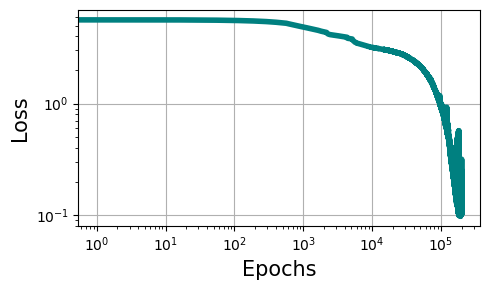

In [10]:
import matplotlib.pyplot as plt

# Print and Plot Loss 
print("Loss: ","%.5g" % losses[-1])
plt.figure(figsize=(5,3))
plt.plot(losses[0:], color = 'teal',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

fig_name = 'loss_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

5.862177167488014 2


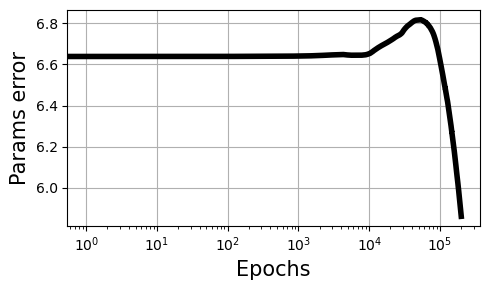

In [11]:
# Print and Plot R2 
# print(np.round(r2_store[-1],2))
print(r2_store[-1],2)

plt.figure(figsize=(5,3))
plt.plot(r2_store, color = 'black',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Params error',fontsize=15)
plt.xscale('log')

plt.tight_layout()

fig_name = 'error_short'
if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_2096\378852007.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges


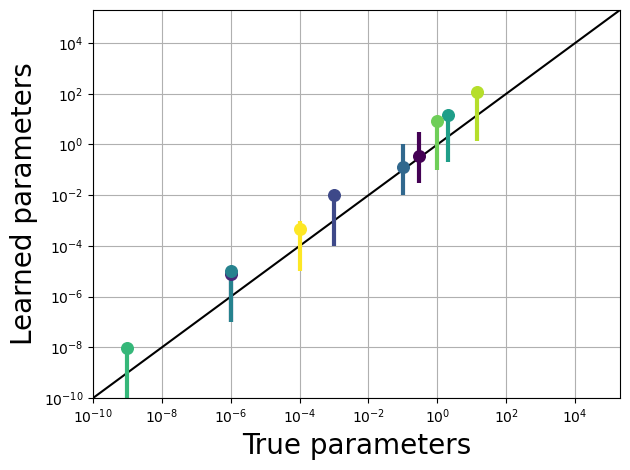

In [12]:
# Comparing parameters
learned_parameters = [pinn_cell.output_param_range(v,i).item() for (i,(k,v)) in enumerate(pinn_cell.ode_parameters.items())]
true_parameters = [k_tr,K_pol,k_rdeg,k_tl,K_rib,k_exc,K_T_rep,k_tp,k_cat,k_M]


plt.grid('true')
plt.plot([0, 2*10**5], [0, 2*10**5],color='black')
plt.scatter(true_parameters,learned_parameters)
plt.xscale('log')
plt.yscale('log')

cmap = plt.cm.get_cmap('viridis', len(ranges))  # Get a colormap with as many colors as there are ranges

# Map each range index to a color from the colormap
colors = [cmap(i) for i in range(len(ranges))]


for i, (true_val, learned_val) in enumerate(zip(true_parameters, learned_parameters)):
    plt.scatter(true_val, learned_val, s=70, color=colors[i], label=f'Range {i}' if i == 0 else "",zorder=3)

    # Also color the corresponding vertical line
    plt.vlines(x=true_val, ymin=ranges[i][0], ymax=ranges[i][1], colors=colors[i],zorder=2,linewidth=3)


min_value = min(r[0] for r in ranges)
max_value = max(r[1] for r in ranges)
plt.ylim([10**(-10),2*10**5])
plt.xlim([10**(-10),2*10**5])

plt.xlabel('True parameters',fontsize=20)
plt.ylabel('Learned parameters',fontsize=20)

plt.tight_layout()

fig_name = 'params_short'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

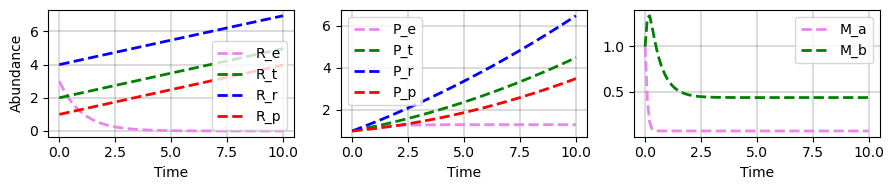

In [13]:
# Plot the solved variables
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2))

ax0.plot(t, R_e, 'violet', lw=2, linestyle='dashed', label='R_e')
ax0.plot(t, R_t, 'green', lw=2, linestyle='dashed',label='R_t')
ax0.plot(t, R_r, 'blue', lw=2, linestyle='dashed',label='R_r')
ax0.plot(t, R_p, 'red', lw=2, linestyle='dashed',label='R_p')

ax0.grid(True, which='major', c='black', lw=0.2, ls='-')
ax0.legend()

ax1.plot(t, P_e, 'violet', lw=2, linestyle='dashed',label='P_e')
ax1.plot(t, P_t, 'green', lw=2, linestyle='dashed',label='P_t')
ax1.plot(t, P_r, 'blue', lw=2, linestyle='dashed',label='P_r')
ax1.plot(t, P_p, 'red', lw=2, linestyle='dashed',label='P_p')

ax1.grid(True, which='major', c='black', lw=0.2, ls='-')
ax1.legend()

ax2.plot(t, M_a, 'violet', lw=2, linestyle='dashed',label='M_a')
ax2.plot(t, M_b, 'green', lw=2, linestyle='dashed',label='M_b')

ax2.grid(True, which='major', c='black', lw=0.2, ls='-')
ax2.legend()

ax0.set_ylabel('Abundance')
ax0.set_xlabel('Time')
ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

plt.tight_layout()

fig_name = 'myodes'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

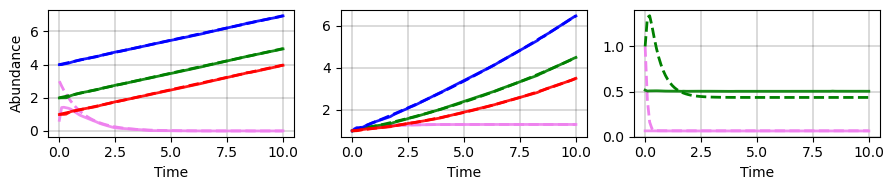

In [14]:
# Plot the solved variables
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2))

ax0.plot(t, R_e, 'violet', lw=2, linestyle='dashed', label='R_e')
ax0.plot(t, R_e_pred.detach().numpy(), 'violet', alpha=0.9, lw=2, label='R_e_learned')
ax0.plot(t, R_t, 'green', lw=2, linestyle='dashed',label='R_t')
ax0.plot(t, R_t_pred.detach().numpy(), 'green', alpha=0.9, lw=2, label='R_t_learned')
ax0.plot(t, R_r, 'blue', lw=2, linestyle='dashed',label='R_r')
ax0.plot(t, R_r_pred.detach().numpy(), 'blue', alpha=0.9, lw=2, label='R_r_learned')
ax0.plot(t, R_p, 'red', lw=2, linestyle='dashed',label='R_p')
ax0.plot(t, R_p_pred.detach().numpy(), 'red', alpha=0.9, lw=2, label='R_p_learned')

ax0.grid(True, which='major', c='black', lw=0.2, ls='-')
#ax0.legend()

ax1.plot(t, P_e, 'violet', lw=2, linestyle='dashed',label='P_e')
ax1.plot(t, P_e_pred.detach().numpy(), 'violet', alpha=0.9, lw=2, label='P_e_learned')
ax1.plot(t, P_t, 'green', lw=2, linestyle='dashed',label='P_t')
ax1.plot(t, P_t_pred.detach().numpy(), 'green', alpha=0.9, lw=2, label='P_t_learned')
ax1.plot(t, P_r, 'blue', lw=2, linestyle='dashed',label='P_r')
ax1.plot(t, P_r_pred.detach().numpy(), 'blue', alpha=0.9, lw=2, label='P_r_learned')
ax1.plot(t, P_p, 'red', lw=2, linestyle='dashed',label='P_p')
ax1.plot(t, P_p_pred.detach().numpy(), 'red', alpha=0.9, lw=2, label='P_p_learned')

ax1.grid(True, which='major', c='black', lw=0.2, ls='-')
#ax1.legend()

ax2.plot(t, M_a, 'violet', lw=2, linestyle='dashed',label='M_a')
ax2.plot(t, M_a_pred.detach().numpy(), 'violet', alpha=0.9, lw=2, label='M_a_learned')
ax2.plot(t, M_b, 'green', lw=2, linestyle='dashed',label='M_b')
ax2.plot(t, M_b_pred.detach().numpy(), 'green', alpha=0.9, lw=2, label='M_b_learned')

ax2.grid(True, which='major', c='black', lw=0.2, ls='-')
#ax2.legend()

ax0.set_ylabel('Abundance')
ax0.set_xlabel('Time')
ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

plt.tight_layout()

fig_name = 'myodes_learned_short'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

## Reconstruct values with learned parameters

In [15]:
# Integrate the SIR equations over the time grid, t.
ret_learned = odeint(deriv, y0, t, args=tuple(learned_parameters))
R_e_learned, R_t_learned, R_r_learned, R_p_learned, P_e_learned, P_t_learned, P_r_learned, P_p_learned, M_a_learned, M_b_learned = ret_learned.T

In [16]:
learned_series = [R_e_pred, 
                  R_t_pred, 
                  R_r_pred, 
                  R_p_pred, 
                  P_e_pred, 
                  P_t_pred, 
                  P_r_pred, 
                  P_p_pred, 
                  M_a_pred, 
                  M_b_pred]


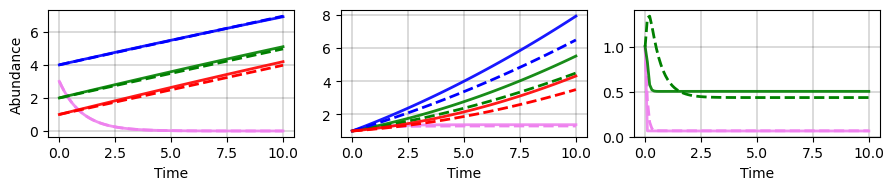

In [17]:
# Plot the solved variables
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(9,2))

ax0.plot(t, R_e, 'violet', lw=2, linestyle='dashed', label='R_e')
ax0.plot(t, R_e_learned, 'violet', alpha=0.9, lw=2, label='R_e_learned')
ax0.plot(t, R_t, 'green', lw=2, linestyle='dashed',label='R_t')
ax0.plot(t, R_t_learned, 'green', alpha=0.9, lw=2, label='R_t_learned')
ax0.plot(t, R_r, 'blue', lw=2, linestyle='dashed',label='R_r')
ax0.plot(t, R_r_learned, 'blue', alpha=0.9, lw=2, label='R_r_learned')
ax0.plot(t, R_p, 'red', lw=2, linestyle='dashed',label='R_p')
ax0.plot(t, R_p_learned, 'red', alpha=0.9, lw=2, label='R_p_learned')

ax0.grid(True, which='major', c='black', lw=0.2, ls='-')
#ax0.legend()

ax1.plot(t, P_e, 'violet', lw=2, linestyle='dashed',label='P_e')
ax1.plot(t, P_e_learned, 'violet', alpha=0.9, lw=2, label='P_e_learned')
ax1.plot(t, P_t, 'green', lw=2, linestyle='dashed',label='P_t')
ax1.plot(t, P_t_learned, 'green', alpha=0.9, lw=2, label='P_t_learned')
ax1.plot(t, P_r, 'blue', lw=2, linestyle='dashed',label='P_r')
ax1.plot(t, P_r_learned, 'blue', alpha=0.9, lw=2, label='P_r_learned')
ax1.plot(t, P_p, 'red', lw=2, linestyle='dashed',label='P_p')
ax1.plot(t, P_p_learned, 'red', alpha=0.9, lw=2, label='P_p_learned')

ax1.grid(True, which='major', c='black', lw=0.2, ls='-')
#ax1.legend()

ax2.plot(t, M_a, 'violet', lw=2, linestyle='dashed',label='M_a')
ax2.plot(t, M_a_learned, 'violet', alpha=0.9, lw=2, label='M_a_learned')
ax2.plot(t, M_b, 'green', lw=2, linestyle='dashed',label='M_b')
ax2.plot(t, M_b_learned, 'green', alpha=0.9, lw=2, label='M_b_learned')

ax2.grid(True, which='major', c='black', lw=0.2, ls='-')
#ax2.legend()

ax0.set_ylabel('Abundance')
ax0.set_xlabel('Time')
ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

plt.tight_layout()

fig_name = 'myodes_learned_short'

if save_fig_choice:
    plt.savefig(path_to_save+fig_name+'.svg', format='svg')

plt.show()

In [18]:
learned_parameters

[0.3450855612754822,
 7.5071861829201225e-06,
 0.00990220159292221,
 0.12606874108314514,
 9.829041118791793e-06,
 14.626187324523926,
 9.824265845281843e-09,
 8.294614791870117,
 121.81371307373047,
 0.00048394163604825735]

In [19]:
true_parameters

[0.3, 1e-06, 0.001, 0.1, 1e-06, 2, 1e-09, 1, 14, 0.0001]

In [20]:
from tools import param_error_percentages
param_error_percentages(true_parameters,learned_parameters)

[0.1502852042516073,
 6.507186182920123,
 8.902201592922209,
 0.26068741083145136,
 8.829041118791793,
 6.313093662261963,
 8.824265845281841,
 7.294614791870117,
 7.700979505266462,
 3.8394163604825735]